<a href="https://colab.research.google.com/github/gaborvecsei/Stocks-Pattern-Analyzer/blob/master/Time_Series_Matcher.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance stumpy &> /dev/null

In [14]:
import numpy as np
import pandas as pd

from sklearn import metrics
import yfinance
import stumpy

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
stock_tickers = ["AAPL", "MSFT", "TSLA", "BABA"]

In [4]:
stock_close_values = dict()

for t in stock_tickers:
    close_vals = yfinance.Ticker(t).history(period="max", interval="1d")["Close"].values
    stock_close_values[t] = close_vals

In [5]:
# Number of values (days) in the data
{t:x.shape[0] for t, x in stock_close_values.items()}

{'AAPL': 10109, 'BABA': 1593, 'MSFT': 8784, 'TSLA': 2657}

------------------------

In [6]:
def normalize(x):
    return (x - np.min(x))/np.ptp(x)

In [7]:
ANCHOR_STOCK_TICKER = "AAPL"
WIN = 14

In [12]:
day_values = stock_close_values[ANCHOR_STOCK_TICKER]

In [13]:
anchor_series_start = len(day_values)-WIN-14
anchor_series_end = anchor_series_start + WIN
anchor_series = day_values[anchor_series_start:anchor_series_end]
anchor_series_norm = normalize(anchor_series)

In [21]:
window_len = len(anchor_series)

similarities_dict = dict()

for t, v in stock_close_values.items():
    sims = []
    subseries_indexes = []

    for i in range(0, len(v)-window_len, window_len):
        s = normalize(v[i:i+window_len])
        subseries_indexes.append((i, i+window_len))

        sim = sum(abs(anchor_series_norm - s))
        sims.append(sim)
    
    similarities_dict[t] = {"similarities":sims, "indexes":subseries_indexes}

In [23]:
for t in similarities_dict.keys():
    vals = similarities_dict[t]["similarities"]
    top_3 = np.argsort(vals)[:3]
    top_3_with_scores = {a:similarities_dict[t]["similarities"][a] for a in top_3}

    print(f"{t} --> {top_3_with_scores}")

AAPL --> {5: 1.2206759938242724, 461: 1.2287519405444198, 107: 1.2702489701070518}
MSFT --> {155: 1.4161662482203594, 568: 1.433361632517533, 234: 1.607699584492336}
TSLA --> {28: 1.5494900813911539, 51: 1.5623124379967028, 135: 1.5688350237483388}
BABA --> {108: 1.447882482997728, 32: 1.6756361754016016, 46: 1.6878543073348133}


In [41]:
CHOSEN_CLOSEST_STOCK = "BABA"

In [42]:
closest_series_indexes = subseries_indexes[np.argmin(similarities_dict[CHOSEN_CLOSEST_STOCK]["similarities"])]

In [43]:
closest_series_start, closest_series_end = closest_series_indexes
closest_series = day_values[closest_series_start:closest_series_end]
closest_series_norm = normalize(closest_series)

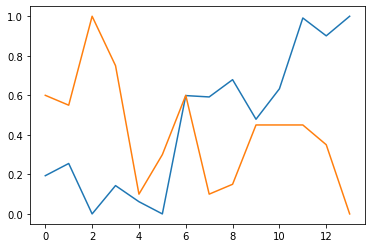

In [44]:
plt.plot(range(0, len(anchor_series_norm)), anchor_series_norm)
plt.plot(range(0, len(closest_series_norm)), closest_series_norm);

In [45]:
FUTURE_WIN = 28
PAST_WIN = 28

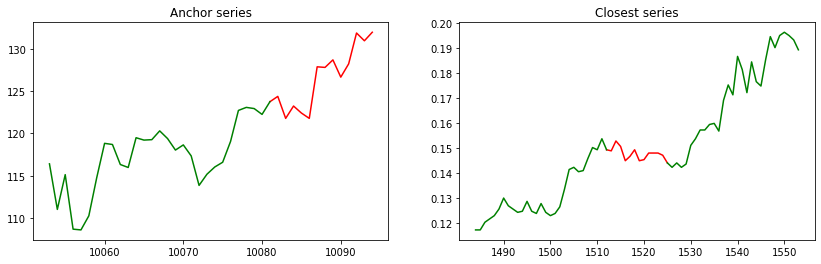

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

indices_anchor = np.arange(anchor_series_start, anchor_series_end, 1)
indices_anchor_future = np.arange(anchor_series_end-1, anchor_series_end+FUTURE_WIN, 1)
anchor_future = day_values[anchor_series_end-1:anchor_series_end+FUTURE_WIN]
indices_anchor_past = np.arange(anchor_series_start-PAST_WIN, anchor_series_start+1, 1)
anchor_past = day_values[anchor_series_start-PAST_WIN:anchor_series_start+1]

axs[0].plot(indices_anchor, anchor_series, color="r")
try:
    axs[0].plot(indices_anchor_future, anchor_future, color="g")
except:
    pass
axs[0].plot(indices_anchor_past, anchor_past, color="g")
axs[0].set_title("Anchor series")

indices_closest = np.arange(closest_series_start, closest_series_end, 1)
indices_closest_future = np.arange(closest_series_end-1, closest_series_end+FUTURE_WIN, 1)
closest_future = day_values[closest_series_end-1:closest_series_end+FUTURE_WIN]
indices_closest_past = np.arange(closest_series_start-PAST_WIN, closest_series_start+1, 1)
closest_past = day_values[closest_series_start-PAST_WIN:closest_series_start+1]

axs[1].plot(indices_closest, closest_series, color="r")
axs[1].plot(indices_closest_future, closest_future, color="g")
axs[1].plot(indices_closest_past, closest_past, color="g")
axs[1].set_title("Closest series");

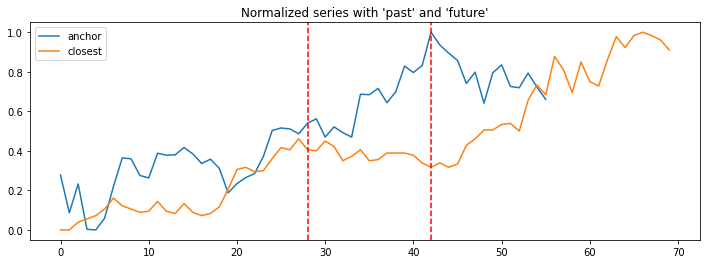

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
ax.plot(normalize(day_values[anchor_series_start-PAST_WIN:anchor_series_end+FUTURE_WIN]), label="anchor")
ax.plot(normalize(day_values[closest_series_start-PAST_WIN:closest_series_end+FUTURE_WIN]), label="closest")
ax.axvline(x=PAST_WIN, color="r", linestyle="--")
ax.axvline(x=PAST_WIN+WIN, color="r", linestyle="--")
ax.set_title("Normalized series with 'past' and 'future'")
ax.legend();